In [1]:
import pandas as pd
import asyncio
import nest_asyncio
nest_asyncio.apply()
import json
import aiohttp
from understat import Understat
import random
import dataframe_image as dfi
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
def calculateWinner(home, away):
    HomeGoals = 0
    AwayGoals = 0
    
    def testShots(shots):
        Goals = 0
        
        for shot in shots:
            if random.random() <= shot:
                Goals += 1
        return Goals
    
    HomeGoals = testShots(home)
    AwayGoals = testShots(away)
    
    if HomeGoals > AwayGoals:
        return("home")
    elif AwayGoals > HomeGoals:
        return("away")
    else:
        return("draw")

In [3]:
#Run xG calculator 10000 times to test winner %
def calculateChance(team1, team2):
    home = 0;
    away = 0;
    draw = 0;
    
    for i in range(0,10000):
        matchWinner = calculateWinner(team1,team2)
        if matchWinner == "home":
            home +=1
        elif matchWinner == "away":
            away +=1
        else:
            draw +=1
    home = home/100
    away = away/100
    draw = draw/100
    return home, away, draw

In [4]:
async def get_win_percent(match_id):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_match_shots(match_id)
        d = json.dumps(players)
        with open('data.json', 'w') as f:
            json.dump(players, f)
        home = pd.DataFrame.from_dict(players['h'], orient='columns')
        away = pd.DataFrame.from_dict(players['a'], orient='columns')
        fixtures = await understat.get_league_results("epl",2020)
        results = pd.DataFrame.from_dict(fixtures, orient='columns')
        homexg = home['xG'].tolist()
        awayxg = away['xG'].tolist()
        h_team = home.iloc[0]['h_team']
        a_team = away.iloc[0]['a_team']
        homexg = list(map(float, homexg))
        awayxg = list(map(float, awayxg))
        h, a, d = calculateChance(homexg, awayxg)
        print("Over 10000 games, {} wins {}%, {} wins {}% and there is a draw in {}% of games.".format(h_team,h,a_team, a, d))
        
        #create a pie chart
        #start with setting up the dataset
        outcomes = [h_team, a_team, 'Draw']
        data = [h, a, d]
        
        #create explode data
        explode = (0.1, 0.1, 0.1)
        
        #creating color parameters
        colors = ("orange", "cyan", "grey")
        
        #wedge properties
        wp = { 'linewidth' : 1, 'edgecolor' : "black" }
        
        #creating autocpt arguments 
        def func(pct, allvalues): 
            absolute = int(pct / 100.*np.sum(allvalues)) 
            return "{:.1f}%\n".format(pct, absolute) 
        
        #creating plot 
        fig, ax = plt.subplots(figsize =(10, 7),facecolor='white') 
        wedges, texts, autotexts = ax.pie(data, autopct = lambda pct: func(pct, data), explode = explode,
                                          labels = outcomes, shadow = True, colors = colors, startangle = 90, 
                                          wedgeprops = wp, textprops = dict(color ="maroon")) 
    
        plt.setp(autotexts, size = 8, weight ="bold") 
        ax.set_title("Win Percentage of 10000 Simulated Games for " + h_team + " vs " + a_team) 

        #save and show plot 
        fig
        plt.savefig("sim_piechart.png",dpi=200)
        plt.show()
        
loop = asyncio.get_event_loop()

In [5]:
async def get_table(season_id,league):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        fixtures = await understat.get_league_results(league,season_id)
        results = pd.DataFrame.from_dict(fixtures, orient='columns')
        l = len(results)
        for i in range(0,l):
            matc_id = results.iloc[i]['id']
            players = await understat.get_match_shots(matc_id)
            home = pd.DataFrame.from_dict(players['h'], orient='columns')
            away = pd.DataFrame.from_dict(players['a'], orient='columns')
            homexg = home['xG'].tolist()
            awayxg = away['xG'].tolist()
            homexg = list(map(float, homexg))
            awayxg = list(map(float, awayxg))
            h,a,d = calculateChance(homexg, awayxg)
            h_team = home.iloc[0]['h_team']
            a_team = away.iloc[0]['a_team']
            pts.iloc[1][h_team] = pts.iloc[1][h_team] + 1.0
            pts.iloc[1][a_team] = pts.iloc[1][a_team] + 1.0
            pts.iloc[0][h_team] = pts.iloc[0][h_team] + (h/100)*3
            pts.iloc[0][a_team] = pts.iloc[0][a_team] + (a/100)*3
            pts.iloc[0][h_team] = pts.iloc[0][h_team] + (d/100)*1
            pts.iloc[0][a_team] = pts.iloc[0][a_team] + (d/100)*1
loop = asyncio.get_event_loop()

Please enter the match id: 14698
Over 10000 games, Chelsea wins 93.23%, Everton wins 1.05% and there is a draw in 5.72% of games.


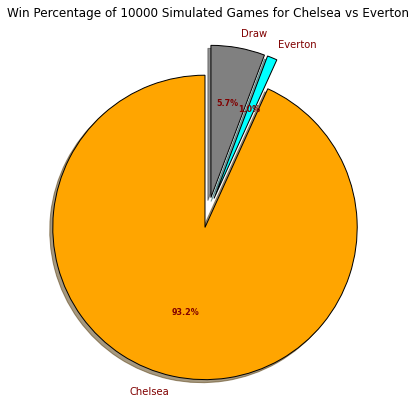

In [6]:
#Enter any match id you want
match_id = input('Please enter the match id: ')
asyncio.run(get_win_percent(match_id))

In [7]:
pts = pd.DataFrame({'Liverpool': [0], 'Manchester City':[0], 'Chelsea':[0], 'Leicester':[0], 'Manchester United':[0], 'Tottenham':[0], 'Wolverhampton Wanderers':[0], 'Sheffield United':[0], 'Burnley':[0], 'Arsenal':[0], 'Southampton':[0], 'Everton':[0], 'Newcastle United':[0], 'Crystal Palace':[0], 'West Ham':[0], 'Brighton':[0], 'Leeds':[0], 'Aston Villa':[0], 'West Bromwich Albion':[0], 'Fulham':[0]})
pts.loc[len(pts)] = 0
pts = pts.astype(float)
asyncio.run(get_table(2019,"epl"))
table = pts.transpose()
table.columns = ['Expected points','Games played']
table = table.sort_values(['Expected points'], ascending=[False])
table.dfi.export('table.png')
print('Expected points table generated')

Expected points table generated
